In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Load training and test data

In [2]:
training = pd.read_csv('data/train.csv')
training.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
testing = pd.read_csv('data/test.csv')
testing.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


Check % of survivors by gender

In [4]:
women = training.loc[training.Sex == 'female']['Survived']
rate_women = sum(women)/len(women)
print(rate_women, "% of women survived")

0.7420382165605095 % of women survived


In [5]:
men = training.loc[training.Sex == 'male']['Survived']
rate_men = sum(men)/len(men)
print(rate_men, "% of men survived")

0.18890814558058924 % of men survived


Random Forest Model

In [6]:
#from sklearn.ensemble import RandomForestClassifier

#y = training["Survived"]

#features = ["Pclass", "Sex", "SibSp", "Parch"]
#X = pd.get_dummies(training[features])
#X_test = pd.get_dummies(testing[features])

#model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
#model.fit(X, y)
#predictions = model.predict(X_test)

#output = pd.DataFrame({'PassengerId': testing.PassengerId, 'Survived': predictions})
#output.to_csv('my_submission.csv', index=False)
#print("Your submission was successfully saved!")
print("lines commented for future submission")

lines commented for future submission


The above code results in 75% correct predictions.  Looking through the given dataset some basic EDA could be done to increase the accuracy.  There are a lot of missing values.  Additionally it might help to figure out names in a family.

In order to refine results I start following the https://www.kaggle.com/allohvk/captivating-conversations-with-the-titanic-dataset guide which gives insight into techniques to improve the fit.

In [7]:
training.info()
#This line reveals that the age, cabin, and embarked fields are missing values.  The age column in particular is missing many values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


Find the number of passengers in each class and then a percentage of each class that survived

In [9]:
global blankline
blankline = '\n*****************************\n'
print(training.groupby('Pclass').count())
print(blankline, training [['Pclass','Survived']].groupby('Pclass').mean())

        PassengerId  Survived  Name  Sex  Age  SibSp  Parch  Ticket  Fare  \
Pclass                                                                      
1               216       216   216  216  186    216    216     216   216   
2               184       184   184  184  173    184    184     184   184   
3               491       491   491  491  355    491    491     491   491   

        Cabin  Embarked  
Pclass                   
1         176       214  
2          16       184  
3          12       491  

*****************************
         Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363


This shows that first class passengers had the highest survival rate by a large margin.
We already know approximately 74% of female passengers survived but let's check survival by gender and ticket class.

In [10]:
print(round(training [['Sex', 'Pclass','Survived']].\
                       groupby(['Pclass', 'Sex']).mean()*100,1))

               Survived
Pclass Sex             
1      female      96.8
       male        36.9
2      female      92.1
       male        15.7
3      female      50.0
       male        13.5


First and second class females had a very high chance of survival compared to any other group.
Next a few visualizations would be helpful in understanding different relationships in the data.
The first graph will visualize how age affects survival rates

AxesSubplot(0.125,0.125;0.775x0.755)


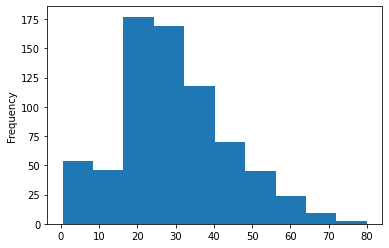

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
print(training['Age'].plot(kind='hist',bins=10))

Knowing females were more likely to survive than males it is important to know the age distribution by gender as well.

<AxesSubplot:xlabel='Age', ylabel='Density'>

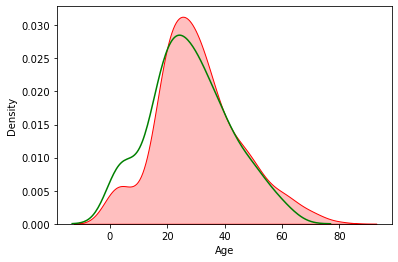

In [12]:
plt.figure()
sns.kdeplot(training[training.Sex=='female']['Age'], color="green")
sns.kdeplot(training[training.Sex=='male']['Age'], color="red", shade=True)

This graph shows young people are more likely to survive and young females are especially likely to survive.  Next it will be helpful to break up the data by passenger class.  To do this we can use a violin plot of age and p-class.  Green represents survival while red is death.

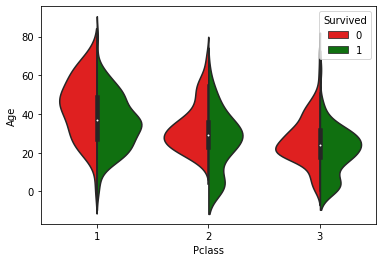

In [13]:
plt.figure() 
sns.violinplot(x='Pclass', y='Age', hue='Survived', split=True ,data=training, palette={0: "r", 1: "g"});

This graph is gives us an interesting understanding of survival rates based on age and ticket class.  

In [14]:
print('Pclass 1 survivors above Age 60:', round(len(training[(training['Pclass']==1) & \
    (training['Age']>59) & (training['Survived']==True)])/len(training[(training\
    ['Pclass']==1) & (training['Age']>59)])*100,1), '%')
print('Pclass 2 survivors above Age 60:', round(len(training[(training['Pclass']==2) & \
    (training['Age']>59) & (training['Survived']==True)])/len(training[(training \
    ['Pclass']==2) & (training['Age']>59)])*100,1), '%')
print('Pclass 3 survivors above Age 60:', round(len(training[(training['Pclass']==3) & \
    (training['Age']>59) & (training['Survived']==True)])/len(training[(training \
    ['Pclass']==3) & (training['Age']>59)])*100,1), '%')

print('Pclass1 survivors between 20-30 Age:',round(len(training[(training['Pclass']==1) \
    &(training['Age']>19) & (training['Age']<31) & (training['Survived']==True)])/len( \
    training[(training['Pclass']==1) & (training['Age']>19) \
    & (training['Age']<31)])*100,1),'%')
print('Pclass2 survivors between 20-30 Age:',round(len(training[(training['Pclass']==2) \
    &(training['Age']>19) & (training['Age']<31) &(training['Survived']==True)])/len( \
    training[(training['Pclass']==2)&(training['Age']>19) \
    &(training['Age']<31)])*100,1),'%')
print('Pclass3 survivors between 20-30 Age:',round(len(training[(training['Pclass']==3) \
    &(training['Age']>19) & (training['Age']<31) &(training['Survived']==True)])/len( \
    training[(training['Pclass']==3) & (training['Age']>19) \
    &(training['Age']<31)])*100,1),'%')

Pclass 1 survivors above Age 60: 29.4 %
Pclass 2 survivors above Age 60: 25.0 %
Pclass 3 survivors above Age 60: 20.0 %
Pclass1 survivors between 20-30 Age: 72.5 %
Pclass2 survivors between 20-30 Age: 41.0 %
Pclass3 survivors between 20-30 Age: 22.6 %


This shows the previous breakdown a little more efficiently demonstrating that first class individuals are very likely to live especially if between the ages of 20-30.  Generally all passengers between 20-30 are more likely to survive than older individuals within their age group.

Next it is helpful to expand on the previous graphs and explore the survivors in each age range categorized by gender.  While it is safe to assume more females will survive in each class it might be helpful to know to what degree.

<AxesSubplot:xlabel='PclassSex', ylabel='Age'>

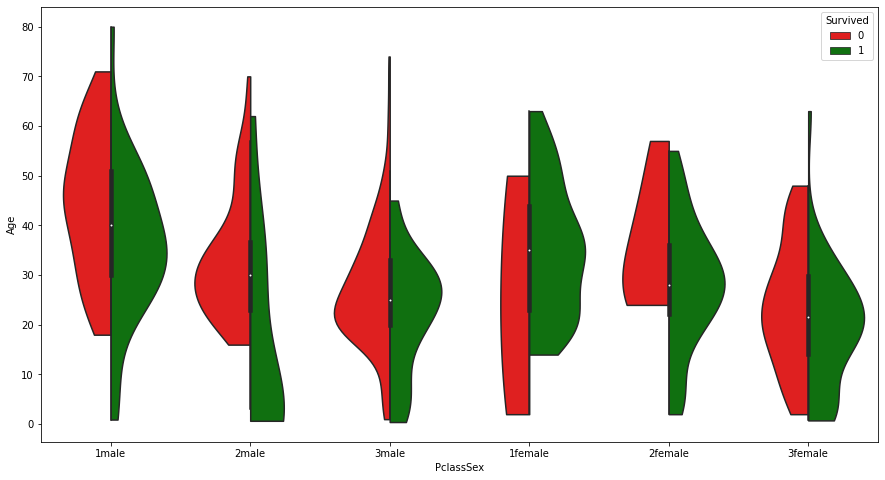

In [15]:
training['PclassSex'] = training['Pclass'].astype(str) + training['Sex'] 


plt.figure(figsize=(15,8))  

sns.violinplot(x='PclassSex', y='Age', hue='Survived', split=True,data=training, cut=0, \
    palette={0: "r", 1: "g"}, order=['1male','2male','3male', '1female', '2female', '3female'])

What this shows is that class 1 females are very likely to survive regardless of age, although being between 20 and 40 is still helpful.  Class 1 males between 20 and 50 seem just as likely to survive as they are to die.  Class 2 males have almost no chance of surviving unless under 10, and class 3 males and females have similar distributions. What is really notable is the difference in pclass 2 and 3 male survival rates in this violin plot.  Let's dissect this quickly.

In [16]:
print('Pclass 2 adult male survivors:',round(len(training[(training['Pclass']==2) & \
        (training['Age']>19) & (training['Sex']=='male') & (training['Survived'] \
        == True)])/len(training[(training['Pclass']==2) & (training['Age']>19) & \
        (training['Sex']=='male')])*100,1),'%')

print('Pclass 3 adult male survivors:',round(len(training[(training['Pclass']==3) & \
        (training['Age']>19) & (training['Sex']=='male') & (training['Survived'] \
        == True)])/len(training[(training['Pclass']==3) & (training['Age']>19) & \
        (training['Sex']=='male')])*100,1),'%')

Pclass 2 adult male survivors: 6.2 %
Pclass 3 adult male survivors: 13.7 %


The fact that male survival rates in third class are twice as high as in second class is very interesting.
The next category to investigate is the embarked column.

<Figure size 432x288 with 0 Axes>

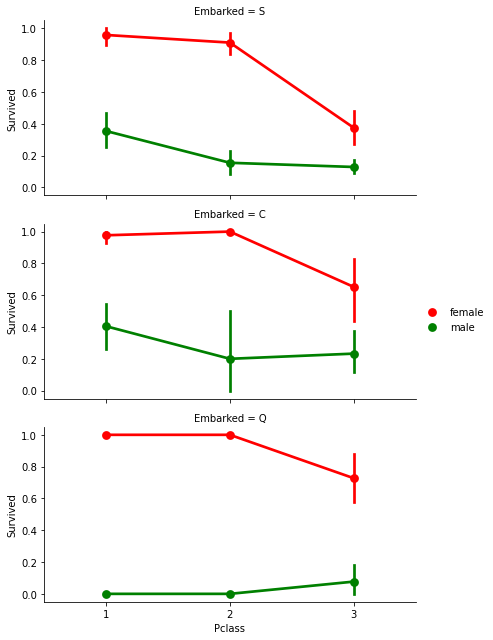

In [17]:
plt.figure()
fg = sns.FacetGrid(training, row='Embarked', aspect=2)
fg.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', \
       hue_order=['female', 'male'], order=[1,2,3], palette={'female': "r", 'male': "g"})
fg.add_legend()

Survival rates seem fairly consistent across embarked ports.
The next category to consider is fare.

In [18]:
print(training['Fare'].describe())

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64


There are people on the boat who did not pay a fare.

In [19]:
print(training[(training['Fare']==0)])
#these are noticably all middle age males so some of these are probably the cabin crew.  

     PassengerId  Survived  Pclass                              Name   Sex  \
179          180         0       3               Leonard, Mr. Lionel  male   
263          264         0       1             Harrison, Mr. William  male   
271          272         1       3      Tornquist, Mr. William Henry  male   
277          278         0       2       Parkes, Mr. Francis "Frank"  male   
302          303         0       3   Johnson, Mr. William Cahoone Jr  male   
413          414         0       2    Cunningham, Mr. Alfred Fleming  male   
466          467         0       2             Campbell, Mr. William  male   
481          482         0       2  Frost, Mr. Anthony Wood "Archie"  male   
597          598         0       3               Johnson, Mr. Alfred  male   
633          634         0       1     Parr, Mr. William Henry Marsh  male   
674          675         0       2        Watson, Mr. Ennis Hastings  male   
732          733         0       2              Knight, Mr. Robe

In [20]:
print(training[(training['Fare']==0)].groupby('Pclass').agg('count'))
#This shows there are 0 cost fares in each pclass

print(training[(training['Fare']==0)].groupby(['Pclass', 'Ticket']).agg('count'))
#All pclass 3 costless tickets have the ticket number LINE which is probably the cabin crew with pclass 3.
#There are missing age values that will need filled and the rest of the fare = 0 should be treated as missing data.


        PassengerId  Survived  Name  Sex  Age  SibSp  Parch  Ticket  Fare  \
Pclass                                                                      
1                 5         5     5    5    3      5      5       5     5   
2                 6         6     6    6    0      6      6       6     6   
3                 4         4     4    4    4      4      4       4     4   

        Cabin  Embarked  PclassSex  
Pclass                              
1           3         5          5  
2           0         6          6  
3           0         4          4  
               PassengerId  Survived  Name  Sex  Age  SibSp  Parch  Fare  \
Pclass Ticket                                                              
1      112050            1         1     1    1    1      1      1     1   
       112052            1         1     1    1    0      1      1     1   
       112058            1         1     1    1    0      1      1     1   
       112059            1         1     1    1  

23 
*****************************

PassengerId    525.043478
Survived         0.043478
Pclass           2.913043
Age             30.825000
SibSp            0.130435
Parch            0.000000
Fare             6.647461
dtype: float64 
*****************************

PassengerId    455.515850
Survived         0.135447
Pclass           3.000000
Age             26.507589
SibSp            0.498559
Parch            0.224784
Fare            12.661633
dtype: float64 
*****************************

     PassengerId  Survived  Pclass                             Name     Sex  \
780          781         1       3             Ayoub, Miss. Banoura  female   
803          804         1       3  Thomas, Master. Assad Alexander    male   

       Age  SibSp  Parch Ticket    Fare Cabin Embarked PclassSex  
780  13.00      0      0   2687  7.2292   NaN        C   3female  
803   0.42      0      1   2625  8.5167   NaN        C     3male  
311
71
10
99


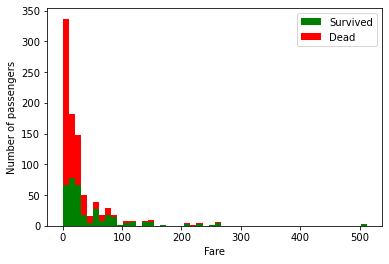

In [21]:
plt.hist([training[training['Survived'] == 1]['Fare'], training[training['Survived'] == 0]['Fare']],
stacked=True, color = ['g','r'], bins = 50, label = ['Survived','Dead'])
plt.xlabel('Fare')
plt.ylabel('Number of passengers')
plt.legend();

#This histogram of fare survival rates demonstrates that higher fares provide higher survival rates, but pclass already shows this well
#It might help to expand on the low fare category

print(len(training[(training['Fare']<7.1) & (training['Fare']>0)]), blankline)
print(training[(training['Fare']<7.1) & (training['Fare']>0)].agg('mean'), blankline)
print(training[(training['Pclass']==3)&(training['Sex']=='male')].agg('mean'),blankline)

#These 23 individuals had a 4.3% survival rate which is abnormally low when it should be around 13.5% as we saw earlier.
#The age is also statistically significant and can be separated and investigated.  

print(training[(training['Fare']<9)&(training['Age']<14)])
print(len(training[(training['Fare']<9)]))
print(len(training[(training['Age']<14)]))

#Out of the 311 people with fare < 9 only 2 of them are children and the rest are amoung the rest of the passengers.
#This means that any missing ages within the 311 low fare passengers belongs to an adult.  Let's narrow down what we can use to fill the ages.
#First lets see how many people in the group are elderly and then how many of them are missing values.

print(len(training[(training['Fare']<9)&(training['Age']>49)]))

#10 people over the age of 49, which means the almost all low fare passengers are middle aged.

print(len(training[(training['Fare']<9)&(training['Age'].isnull())]))

#99 missing values in the group.  Since we've done this analysis we can fill these 99 ages more accurately than doing a generic calculation for all 177 missing age values.

Now we should determine if calculating a fare would be a good idea for the missing fare values.

In [22]:
combined=training.append(testing) #in order to find the number of tickets we need to use both training and testing data
training['PeopleInTicket']=training['Ticket'].map(combined['Ticket'].value_counts())
training['FarePerPerson']=training['Fare']/training['PeopleInTicket']

training['FamilyCount']=training['Parch']+training['SibSp']+1

pd.set_option("display.max_rows", None, "display.max_columns", None)
display(training.head())
print(len(training[training['FamilyCount'] != training['PeopleInTicket']]))

#There are 195 rows where family count doesn't match the number of people in the ticket.

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PclassSex,PeopleInTicket,FarePerPerson,FamilyCount
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,3male,1,7.25000,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1female,2,35.64165,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3female,1,7.92500,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1female,2,26.55000,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,3male,1,8.05000,1


195


In [23]:
print(len(training[(training['FarePerPerson']<7.1) & (training['FarePerPerson']>0) \
    & (training['Survived']==0)]))
print(len(training[(training['FarePerPerson']<7.1) & (training['FarePerPerson']>0) \
    & (training['Survived']==1)]))

96
44


this is a significant finding.  Despite people in the lowest ticket bracket having a 95% expiry rate groups of people had a much higher survival rate than individuals.  It will be helpful to look at things with regards to the group size they bring with them

<AxesSubplot:xlabel='FamilyCount', ylabel='count'>

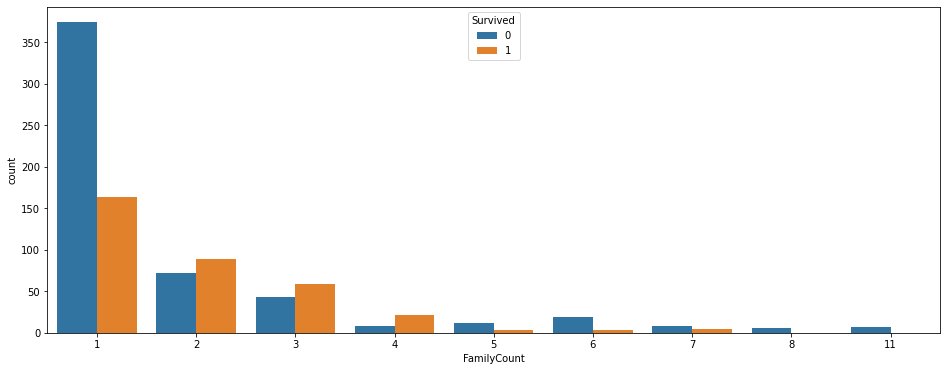

In [24]:
training['GroupSize'] = training[['FamilyCount','PeopleInTicket']].max(axis=1)
plt.figure(figsize=(16, 6))
sns.countplot(x='FamilyCount', hue='Survived', data=training)

This demonstrates the low survival rate of solo travelers on the ship.  Another observation is that traveling with up to 4 is better, but once the group size hits 5 or more the survival rate drops off fully.

In [25]:
print('Between 2-4 familycount in Pclass 1,2: ', len(training[(training.FamilyCount \
        .between(2, 4)) & (training.Pclass.between(1,2))]))
print('Between 2-4 familycount in Pclass 3: ',len(training[(training.FamilyCount \
        .between(2, 4)) & (training.Pclass==3)]))
print('>4 familycount in Pclass 1,2: ',len(training[(training.FamilyCount>4) & \
        (training.Pclass.between(1,2))]))
print('>4 familycount in Pclass 3: ',len(training[(training.FamilyCount>4) & \
        (training.Pclass==3)]))

Between 2-4 familycount in Pclass 1,2:  179
Between 2-4 familycount in Pclass 3:  113
>4 familycount in Pclass 1,2:  8
>4 familycount in Pclass 3:  54


<AxesSubplot:xlabel='FamilyCount', ylabel='count'>

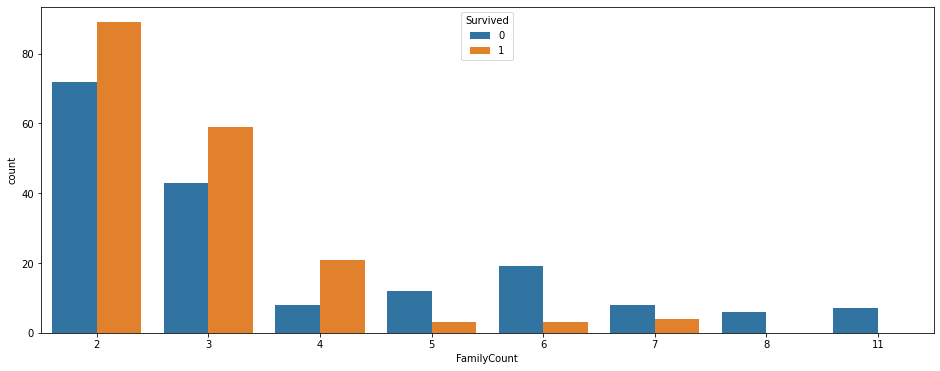

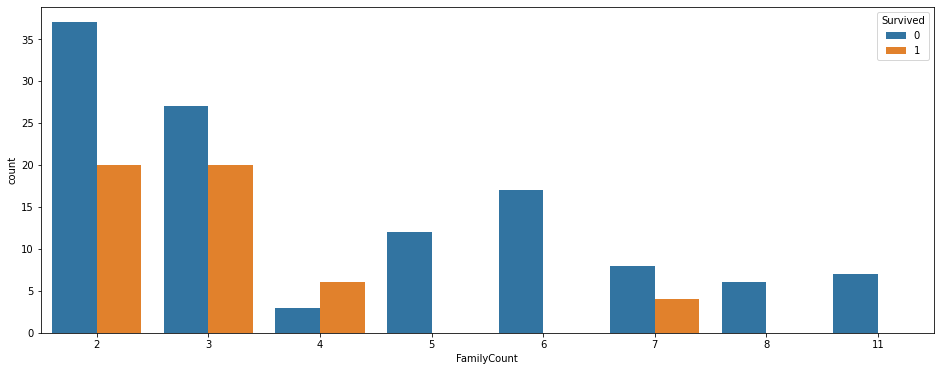

In [26]:
plt.figure(figsize=(16, 6))
sns.countplot(x='FamilyCount', hue='Survived', data=training[(training.FamilyCount > 1)])

plt.figure(figsize=(16, 6))
sns.countplot(x='FamilyCount',hue='Survived',data=training[(training.Pclass==3) \
        & (training.FamilyCount >1)])

This comparison shows the survival rates of groups in class 3.  This shows that besides being solo travelling in a group does not provide much more benefit to survival rates.  Just as a test we should check the survival rates of solo travelers vs the survival rates of genders

In [27]:
print('Mortality rate overall: ', round(len(training[(training.FamilyCount==1) & \
    (training.Survived!=1)]) / len(training[training.FamilyCount==1])*100), '%')

print('Mortality rate Male: ', round(len(training[(training.FamilyCount==1) & \
    (training.Survived!=1) & (training.Sex=='male')]) / len(training[(training\
    .FamilyCount==1)& (training.Sex=='male')])*100), '%')

print('Mortality rate Female: ', round(len(training[(training.FamilyCount==1) & \
    (training.Survived!=1) & (training.Sex=='female')]) / len(training[(\
    training.FamilyCount==1)& (training.Sex=='female')])*100), '%')


Mortality rate overall:  70 %
Mortality rate Male:  84 %
Mortality rate Female:  21 %


Since the survival rate of female travelers was already high it will be useful to graph the mortality rates between female solo travelers and group travelers.

<AxesSubplot:xlabel='FamilyCount', ylabel='count'>

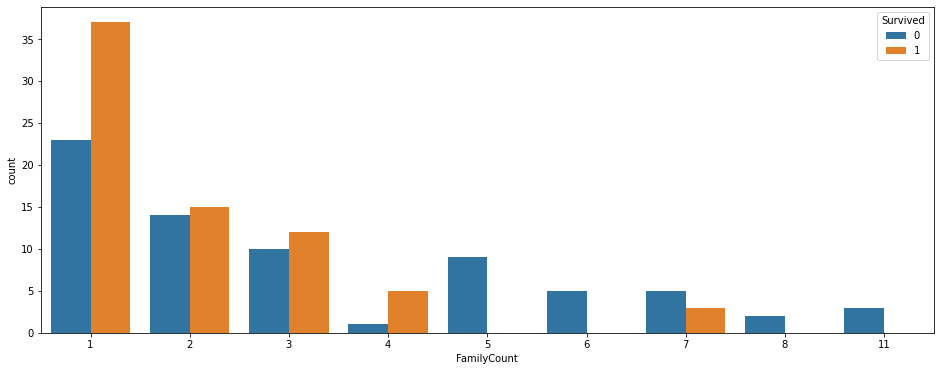

In [28]:
plt.figure(figsize=(16, 6))
sns.countplot(x='FamilyCount',hue='Survived',data=training[(training.Sex=='female') \
    & (training.Pclass==3)])

Here we see an intersting find.  The mortality rate for solo females is much less than the mortality rate for non solo females.  Perhaps females with families were less likely to leave without them making solo females more likely to survive. 
Next we need to investigate the embarked and cabin columns.  These are unlikely to have real effects on survival rates.

In [29]:
#Column for cabin letter
training['CabinLetter'] = training['Cabin'].str[0]

#Display cabin info
print(training.groupby(['CabinLetter', 'Pclass', 'Sex'])['Survived'].agg(['count', 'mean']))

                           count      mean
CabinLetter Pclass Sex                    
A           1      female      1  1.000000
                   male       14  0.428571
B           1      female     27  1.000000
                   male       20  0.400000
C           1      female     27  0.888889
                   male       32  0.343750
D           1      female     16  1.000000
                   male       13  0.461538
            2      female      2  1.000000
                   male        2  0.500000
E           1      female     10  1.000000
                   male       15  0.533333
            2      female      4  0.750000
            3      female      1  1.000000
                   male        2  1.000000
F           2      female      4  1.000000
                   male        4  0.750000
            3      female      1  1.000000
                   male        4  0.000000
G           3      female      4  0.500000
T           1      male        1  0.000000


Cabins A, B, and C are all Pclass 1, D, E, and F contain some 2's and E, F, and G contain Pclass 3's.
Next comes the embarked column

In [30]:
print(training.groupby('Embarked')['Survived'].agg(['count','mean', 'size']))
#Port C has a high survival rate of 55% maybe less 3rd class individuals were on at this port

print(training.groupby(['Embarked', 'Pclass'])['Survived'].agg(['count','mean']))

#Since more first class passengers embarked at port C this explains the high survival rate of the port.

          count      mean  size
Embarked                       
C           168  0.553571   168
Q            77  0.389610    77
S           644  0.336957   644
                 count      mean
Embarked Pclass                 
C        1          85  0.694118
         2          17  0.529412
         3          66  0.378788
Q        1           2  0.500000
         2           3  0.666667
         3          72  0.375000
S        1         127  0.582677
         2         164  0.463415
         3         353  0.189802


Finally we need to explore the name column.  The only real comparison I can do here is by name length.

<AxesSubplot:xlabel='NameLength', ylabel='count'>

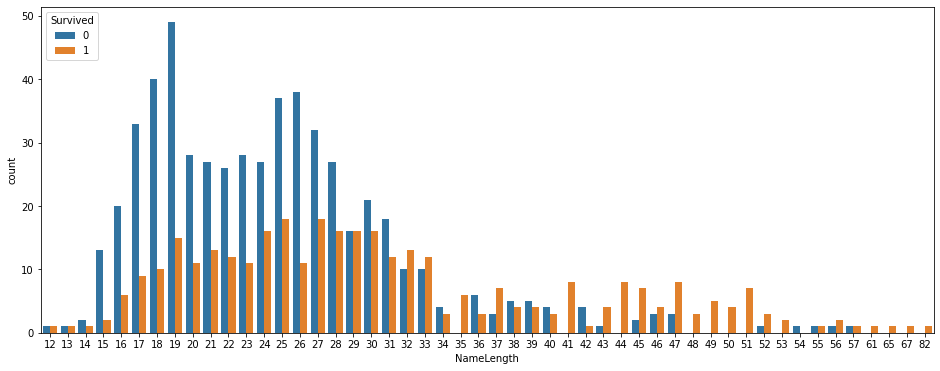

In [31]:
#Create column of name lengths
training["NameLength"] = training["Name"].apply(len).astype(int)

plt.figure(figsize=(16, 6))
sns.countplot(x='NameLength', hue='Survived', data=training)

#What is intersting about this graph is that people with longer names tended to survive more often than they didn't. In order to explore this it might be helpful to see a few of the names with len > 35.

#print(training[training["NameLength"]> 35]) #A long output
#Many of these names are females with maiden names.  This is likely the reason for the name/survival relationship.  The males with long names are less likely to survive than the females in this category.

Having analyized all columns of the data we can draw a few useful conclusions.  Pclass 1 and 2 females almost always survive.  The next reliable indecator is groups.  But not all groups survive as shown earlier.  The key connection is that members within a team have correlated survival.  So it will be helpful to build groups of families on the titanic to use as a good indecator for members which are not female.  First I should fill in some missing values and then create the groupings which will be useful when training. 